## Problem Statement

This kernel focuses on solving a problem as outlined by [the Human Protein Atlas Image Classification Kaggle competition](https://www.kaggle.com/c/human-protein-atlas-image-classification).

As per the competition overview page:

> In this competition, Kagglers will develop models capable of classifying mixed patterns of proteins in microscope images. The Human Protein Atlas will use these models to build a tool integrated with their smart-microscopy system to identify a protein's location(s) from a high-throughput image.

>Proteins are “the doers” in the human cell, executing many functions that together enable life. Historically, classification of proteins has been limited to single patterns in one or a few cell types, but in order to fully understand the complexity of the human cell, models must classify mixed patterns across a range of different human cells.

>Images visualizing proteins in cells are commonly used for biomedical research, and these cells could hold the key for the next breakthrough in medicine. However, thanks to advances in high-throughput microscopy, these images are generated at a far greater pace than what can be manually evaluated. Therefore, the need is greater than ever for automating biomedical image analysis to accelerate the understanding of human cells and disease.

This should be interesting! Let's start with the necessary imports:

## Imports

In [148]:
import pdb
import sys
import time
import pandas as pd
from sklearn.metrics import f1_score
import pathlib
import copy
import pickle
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from matplotlib import style
style.use('seaborn')

import cv2

import numpy as np
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
import torch.nn as nn
from torch import optim, save
import torchvision.models as models

!pip install pytorch-ignite
from ignite.engine import create_supervised_evaluator, create_supervised_trainer
from ignite.engine.engine import Engine
from ignite._utils import convert_tensor
from ignite.engine import Events

Setting the random seed for both NumPy and PyTorch to allow reproducing results:

In [149]:
seed = 5
np.random.seed(seed)
torch.manual_seed(seed)

In [150]:
PATH = pathlib.Path('../input/human-protein-atlas-image-classification')

In [151]:
[item.name for item in PATH.iterdir()]

['train', 'test', 'train.csv', 'sample_submission.csv']

Now let's define a dictionary of protein organelle localisations which will form the basis of our training labels:

In [152]:
labels_txt = """0.  Nucleoplasm  
1.  Nuclear membrane   
2.  Nucleoli   
3.  Nucleoli fibrillar center   
4.  Nuclear speckles   
5.  Nuclear bodies   
6.  Endoplasmic reticulum   
7.  Golgi apparatus   
8.  Peroxisomes   
9.  Endosomes   
10.  Lysosomes   
11.  Intermediate filaments   
12.  Actin filaments   
13.  Focal adhesion sites   
14.  Microtubules   
15.  Microtubule ends   
16.  Cytokinetic bridge   
17.  Mitotic spindle   
18.  Microtubule organizing center   
19.  Centrosome   
20.  Lipid droplets   
21.  Plasma membrane   
22.  Cell junctions   
23.  Mitochondria   
24.  Aggresome   
25.  Cytosol   
26.  Cytoplasmic bodies   
27.  Rods & rings"""

In [153]:
labels = {int(no): protein.strip() for no, protein in [label.split('.') for label in labels_txt.split('\n')]}

In [154]:
def from_id(ID):
    targ = df['Target'][df['Id'] == smpl].values[0]
    return from_target(targ)

def from_target(targ):
    s = ' & '
    t = [labels[int(t)] for t in targ.split(' ')]
    name = s.join(t) if len(t) > 1 else t[0]
    return name

## Importing the dataset

In [155]:
df = pd.read_csv(PATH/'train.csv'); df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


The above dataset provides image `Id`'s wih their respective `Target` labels. The total number of samples is:

In [156]:
df.shape[0]

31072

## Converting the dataset

For further analysis, let's transform the `Target` column into binary features for all labels:

In [157]:
for protein in labels: df[labels[protein]] = df['Target'].apply(lambda x: 1 if str(protein) in x.split(' ') else 0)
df

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,Peroxisomes,Endosomes,Lysosomes,Intermediate filaments,Actin filaments,Focal adhesion sites,Microtubules,Microtubule ends,Cytokinetic bridge,Mitotic spindle,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,001bcdd2-bbb2-11e8-b2ba-ac1f6b6435d0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0020af02-bbba-11e8-b2ba-ac1f6b6435d0,25 2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
7,002679c2-bbb6-11e8-b2ba-ac1f6b6435d0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,00285ce4-bba0-11e8-b2b9-ac1f6b6435d0,2 0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,002daad6-bbc9-11e8-b2bc-ac1f6b6435d0,7,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Time to verify the balance within the dataset classes:

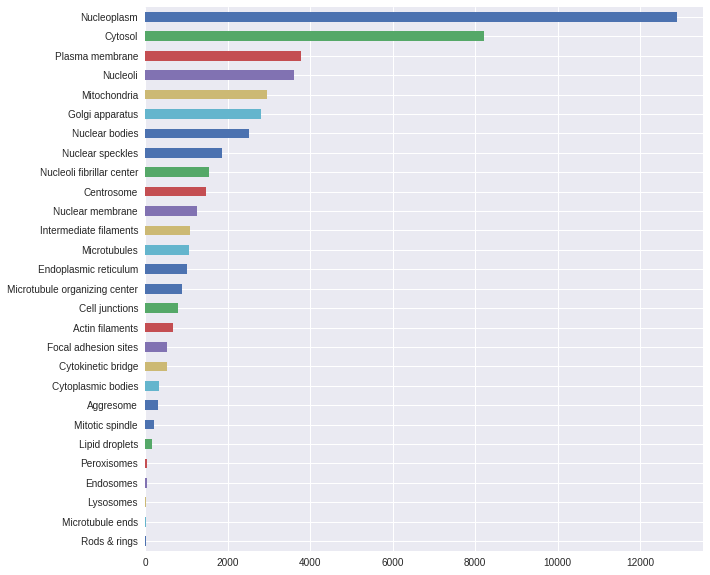

In [158]:
plt.figure(figsize=(10, 10))
df.drop(columns=['Id', 'Target']).sum().sort_values(ascending=False).plot.barh()
plt.gca().invert_yaxis()
plt.show()

In [159]:
counts = df.drop(columns=['Id', 'Target']).sum().sort_values(ascending=False)
for i in range(1, 5): 
    print(f'Top {i} {"labels constitute" if i>1 else "label constitutes"} {counts[:i].sum() / counts.sum() * 100:.2f}% of observations')

Top 1 label constitutes 25.37% of observations
Top 2 labels constitute 41.58% of observations
Top 3 labels constitute 49.01% of observations
Top 4 labels constitute 56.14% of observations


Looks like there is a heavy imbalance in the dataset, in particular towards the top two contributors - Nucleoplasm and Cytosol.

## Data Preprocessing and Augmentation

For each ID in our dataset we get four separate .png images, each covering a different part of the electromagnetic spectrum

In [160]:
[item.name for item in sorted(list((PATH/'train').iterdir()))[:4]]

['00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_blue.png',
 '00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_green.png',
 '00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_red.png',
 '00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png']

We get the four channels for each picture in a separate .png file. This explains why the number of images in the directory is exactly four times higher than the number of labels:

In [161]:
len(list((PATH/'train').iterdir())) / df['Id'].shape[0]

4.0

All images 512x512 color?

In [162]:
full_set = [item.name for item in (PATH/'train').iterdir()]

In [163]:
filter_type = {
    'green': ['protein', 'Greens'],
    'blue': ['nucleus', 'Blues'],
    'red': ['microtubes', 'Reds'],
    'yellow': ['endoplasmic reticulum', 'Oranges']
}

In [164]:
def chan(channels):
    if channels == "G": return 1
    elif channels == "RGB": return 3
    elif channels == "RGBY": return 4
    else: raise Exception("Please provide the correct channel code: [G, RGB, RGBY]")

In [165]:
def from_channels(smpl, channels="RGBY", test=False, gpu=False):
    folder = 'test' if test else 'train'
    ch = chan(channels)
    image = torch.cuda.FloatTensor(ch, 512, 512).fill_(0)
    if ch == 1: image[0, :, :] = torch.cuda.FloatTensor(plt.imread(str(PATH/f'{folder}/{smpl}_green.png')))
    if ch > 2:
        image[0, :, :] = torch.cuda.FloatTensor(plt.imread(str(PATH/f'{folder}/{smpl}_red.png')))
        image[1, :, :] = torch.cuda.FloatTensor(plt.imread(str(PATH/f'{folder}/{smpl}_green.png')))
        image[2, :, :] = torch.cuda.FloatTensor(plt.imread(str(PATH/f'{folder}/{smpl}_blue.png')))

    if ch > 3:
        image[3, :, :] = torch.cuda.FloatTensor(plt.imread(str(PATH/f'{folder}/{smpl}_yellow.png')))
    if not gpu: image = np.swapaxes(image.cpu().data.numpy(),0,-1)
    return image

In [166]:
# def from_channels(smpl, channels="RGBY", test=False):
#     folder = 'test' if test else 'train'
#     ch = chan(channels)
#     image = np.zeros((512, 512, ch))
#     if ch == 1: image[:, :, 0] = plt.imread(str(PATH/f'{folder}/{smpl}_green.png'))
#     if ch > 2:
#         image[:, :, 0] = plt.imread(str(PATH/f'{folder}/{smpl}_red.png'))
#         image[:, :, 1] = plt.imread(str(PATH/f'{folder}/{smpl}_green.png'))
#         image[:, :, 2] = plt.imread(str(PATH/f'{folder}/{smpl}_blue.png'))
        
#     if ch > 3:
#         image[:, :, 3] = plt.imread(str(PATH/f'{folder}/{smpl}_yellow.png'))
#     return image

In [167]:
def visualise(img, name='', h=7, w=7, show=True, a=1.9, figure=None):
    fig = plt.figure(figsize=(h, w)) if figure is None else figure
    plt.grid(False)
    plt.axis('off')
    plt.title(name)
    alpha = 1
    i = 0
    for colour in filter_type:
        try:
            channel = img[:, :, i]
            plt.imshow(channel, cmap=filter_type[colour][1], alpha=alpha)
            alpha /= a
            i += 1
        except IndexError:
            break
    if show: plt.show()

In [168]:
def set_show(ID: str, ):
    print(from_id(ID))
    fig = plt.figure(figsize=(18, 18))
    i = 1
    combined = []
    for colour in filter_type:
        fig.add_subplot(1, 4, i)
        plt.title(filter_type[colour][0])
        fig.gca().grid(False)
        plt.axis('off')
        img = str(PATH/f'train/{ID}_{colour}.png')
        plt.imshow(plt.imread(img), cmap=filter_type[colour][1])
        combined.append([plt.imread(img), filter_type[colour][1]])
        i += 1
    visualise(from_channels(ID), name='COMBINED VIEW')

Visualising a random sample:

Nucleoplasm


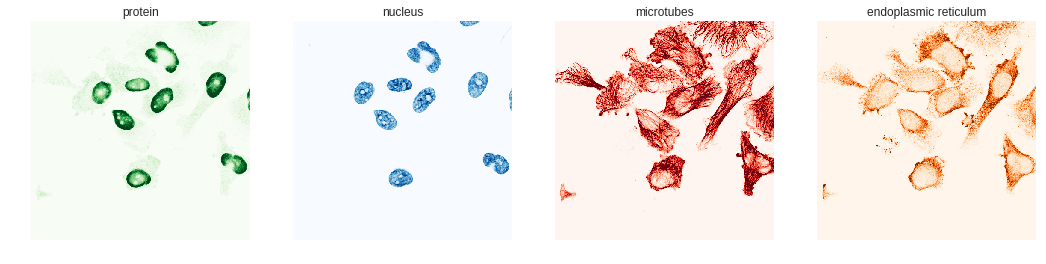

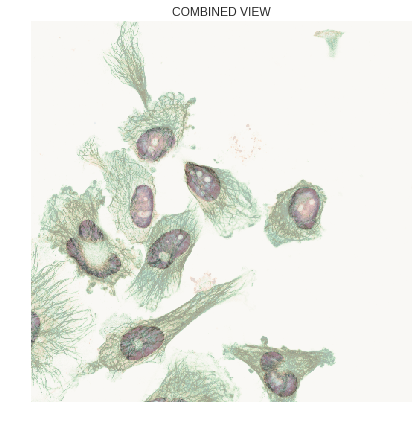

In [169]:
smpl = df['Id'][np.random.randint(0, df.shape[0])]
set_show(smpl)

## Data Augmentation & Preprocessing

Data augs

In [170]:
def augment(img, flip_img=True, tilt_img=True, crop_img=True,
           how='b', randomf=True,
           r=0.2, randomc=True, resize=True,
           angle=20, randomt=True):
    """
    Apply a set of augmentations:
    flip_img (bool) - apply flip 
    tilt_img (bool) - apply tilt 
    crop_img (bool) - apply crop
    """
    if flip_img: img = flip(img, how=how, randomf=randomf)
    if tilt_img: img = tilt(img, angle=angle, randomt=randomt)
    if crop_img: img = crop(img, r=r, randomc=randomc, resize=resize)
    return img


def flip(img, how, randomf=True):
    """
    how -
            'h' - horizontal flip
            'v' - vertical flip
            'b' - both
            'n' - none
    randomf - random selection of 'how' (ignores given value)
    """
    how = np.random.choice(['b', 'v', 'h', 'n']) if randomf else how
    if how != 'n':
        if how != 'h': img = cv2.flip(img, 0)
        if how != 'v': img = cv2.flip(img, 1)
    img = img.reshape(img.shape[0], img.shape[0], -1)
    return img


def crop(img, r, randomc=True, resize=True):
    """
    r - max ratio
    randomc - random rescale of r
    resize - restoring the picture to original size
    """
    r = r * np.random.uniform(low=0.2) if randomc else r
    hmax, wmax = img.shape[:2]
    h = int(hmax * r / 2)
    w = int(img.shape[1] * r / 2)
    img = img[h : hmax-h, w : wmax-w, :] if len(img.shape) > 2 else img[h : hmax-h, w : wmax-w]
    if resize: img = cv2.resize(img, (hmax, wmax))
    img = img.reshape(img.shape[0], img.shape[0], -1)
    return img


def tilt(img, angle, randomt=True):
    """
    angle - rotation angle <0, 90> degrees
    randomt - random resize of angle
    """
    angle = angle * np.random.uniform(low=0.2) * np.random.choice([-1, 1]) if randomt else angle
    row, col = img.shape[:2]
    center = tuple(np.array([row, col]) / 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    img = cv2.warpAffine(img, rot_mat, (col, row))
    return img

In [171]:
img = from_channels(smpl, channels="RGBY")

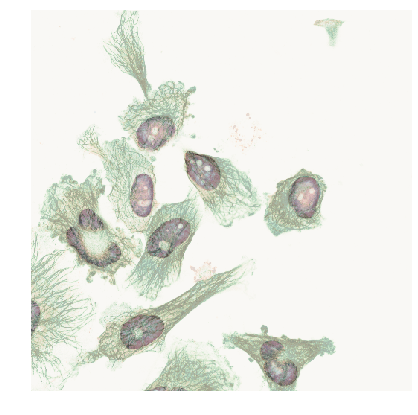

In [172]:
visualise(img)

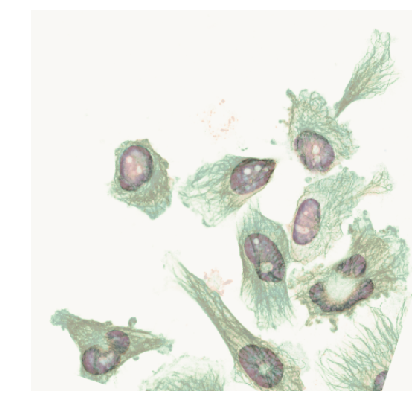

In [173]:
visualise(augment(img))

## Balancing the Dataset
## Training & Validation Sets

we need to preserve the class balance in the training and val datasets, perhaps also introduce weights to sampling in the train loader?

In [174]:
# orig_df = df.copy()
# df = df.sample(frac=0.1)
# # df.shape

In [175]:
def get_val_idxs(df, ratio = 0.3):
    n = int(len(df) * ratio)
    target_abundance = df['Target'].value_counts()
    rare = target_abundance[target_abundance == 1].index
    rare_v = np.random.choice(rare, size=int(len(rare) * ratio))
    target_abundance = target_abundance[target_abundance > 1].append(pd.Series({t: 1 for t in rare_v}))
    freq = target_abundance / target_abundance.sum()
    idxs = []
    for t in freq.index:
        idx_t = df[df['Target'] == t].index
        size = max(1, int(freq[t] * n))
        idxs += list(np.random.choice(idx_t, size=size, replace=False))
    np.random.shuffle(idxs)
    return idxs

In [176]:
idxs = get_val_idxs(df)
idxs = df.index.isin(idxs)
train = df[~idxs].copy()
val = df[idxs].copy()
df.shape, train.shape, val.shape

((31072, 30), (21852, 30), (9220, 30))

oversample minority classes using multiplier based on log of class abundance weights:

In [177]:
def class_multiplier(df, a=0.99):
    class_abundance = df.drop(columns=['Id', 'Target']).sum()
    w = (sum(class_abundance) / class_abundance).apply(lambda x: x if x > 1. else 1.)
    log_w = np.log(a * w).apply(lambda x: x if x > 1. else 1.).astype('int16')
    return log_w


def oversample(df):
    m = class_multiplier(df)
    idxs = [idx for idx in df.index for _ in range(max(df.loc[idx][2:] * m))]
    np.random.shuffle(idxs)
    return idxs

In [178]:
idxs = oversample(train)
train_template = train.loc[idxs].copy()
train = train_template.sample(frac=0.15)  # ONLY TAKE 15% of OBSERVATIONS
train.shape

(7919, 30)

## Modelling

In [179]:
def f1(pred, act, threshold=0.2, average="macro"):
#     pdb.set_trace()
    p = pred.sigmoid().cpu().data.numpy()
    a = act.cpu().data.numpy()
    return f1_score((p > threshold), a, average=average)

Baseline comparison on validation set - all Nucleoplasms

In [180]:
baseline = np.stack([np.array([1] + [0] * (val.shape[1] - 3)) for i in range(val.shape[0])])
ground_truth = val.iloc[:, 2:]
print(f"{f1_score(baseline, ground_truth, average='macro'):.4f}")

0.0209


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Baseline comparison - all labels True:

In [181]:
baseline = np.stack([np.array([1] * (val.shape[1] - 2)) for i in range(val.shape[0])])
ground_truth = val.iloc[:, 2:]
print(f"{f1_score(baseline, ground_truth, average='macro'):.4f}")

0.0990


**Dataset definition**

In [182]:
def resize2d(img, size):
    return (F.adaptive_avg_pool2d(img, size)).data

In [183]:
idx = 3
sz = (128, 128)
label = torch.cuda.FloatTensor(train.iloc[idx, 2:])
ID = train['Id'].iloc[idx]
img = from_channels(ID, channels='G', gpu=True)
if img.shape[1:] != sz:
    img = resize2d(img, sz)
[img, label][0].shape


torch.Size([1, 128, 128])

In [184]:
class ProteinDataset(Dataset):
    
    def __init__(self, dset, channels="RGBY", sz=512, test=False):
        self.dset = dset
        self.channels = channels
        self.sz = (sz, sz)
        self.test = test
        
    def __len__(self):
        return len(self.dset)
    
    def __getitem__(self, idx):
        label = torch.cuda.FloatTensor(self.dset.iloc[idx, 2:])
        ID = self.dset['Id'].iloc[idx]
        img = from_channels(ID, channels=self.channels, test=self.test, gpu=True)
        if img.shape[1:] != self.sz:
            img = resize2d(img, self.sz)
        return [img, label]

**Learning rate finder**

In [185]:
def find_lr(model, train_loader, loss, crop=1, p=10):
    model = copy.deepcopy(model)
    p += crop
    lrs = [round(eval("1e-" + str(p)) * 10**i, p - i) for i in range(p + 1)] + [2]
    losses = []
    for lr in lrs:
        opt = optim.Adam(params=model.parameters(), lr=lr)
        inp, lab = next(iter(train_loader))
        opt.zero_grad()
        out = model(inp)
        loss_size = loss(out, lab)
        loss_size.backward()
        opt.step()
        losses.append(float(loss_size.cpu().data.numpy()))
    los = losses[1 + crop:-crop]
    lrs = lrs[crop:-(crop + 1)]
    plt.plot(los)
    plt.xticks(list(range(len(los))), lrs, rotation='vertical')
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.show()

**Loss functions**

In [186]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, inp, targ):
        if not (targ.size() == inp.size()):
            raise ValueError(f"targ size ({targ.size()}) must be the same as inp size ({inp.size()})")

        max_val = (-inp).clamp(min=0)
        loss = inp - inp * targ + max_val + ((-max_val).exp() + (-inp - max_val).exp()).log()

        invprobs = F.logsigmoid(-inp * (targ * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [187]:
class F1_Loss(nn.Module):
    
    def forward(self, inp, targ):
        inp = inp.sigmoid()
        epsilon = 1e-10

        tp = (inp*targ).sum(dim=0)
        tn = ((1 - inp)*(1-targ)).sum(dim=0)
        fp = (inp*(1-targ)).sum(dim=0)
        fn = ((1-inp)*targ).sum(dim=0)

        precision = tp / (tp + fp + epsilon)
        recall = tp / (tp + fn + epsilon)

        f1 = 2 * precision * recall / (precision + recall + epsilon)
        return 1 - f1.mean()

In [188]:
class Combined_Loss(nn.Module):
    
    def forward(self, inp, targ):
        return F1_Loss().cuda()(inp, targ) + FocalLoss().cuda()(inp, targ)

**Training loop**

In [189]:
def evaluate(model, val_loader, threshold=0.2, average="macro"):
    """
    Evaluation of model performance on the validation set
    """
    preds = []
    acts = []
    for v in val_loader:
        X, y = v
        pred = model(X).sigmoid().cpu().data.numpy()
        act = y.cpu().data.numpy()
        preds.append(pred)
        acts.append(act)
    preds = np.concatenate(preds)
    acts = np.concatenate(acts)
    
    f1 = f1_score(preds > threshold, acts, average=average)
    return f1

In [190]:
# main training loop
def train_cnn(model, train_loader, val_loader, n_epochs, lr, 
              channels="RGBY", prints_per_epoch=10, annealing=True, cycles=1, t=0.5):
    print("HYPERPARAMETERS\n", "_"*30, f"\nBatch size (w. augs): {bs}\nLearning rate: {lr}\nNumber of Epochs: {n_epochs}\n", "_"*30)  
    n_batches = len(train_loader)
    training_start_time = time.time()
    print_every = n_batches // prints_per_epoch
    print_loss = []
    
#     loss=FocalLoss().cuda()
    loss=F1_Loss().cuda()
#     loss=Combined_Loss().cuda()
    
    opt = optim.Adam(model.parameters(), lr=lr)
    

    # Main loop:
    for epoch in range(n_epochs):
        running_loss = 0.0
        start_time = time.time()
        total_train_loss = 0
        
        # reset the scheduler:
        if epoch % cycles == 0: 
            scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, len(train_loader) * cycles, eta_min=lr/1e4)
        
        for i, data in enumerate(train_loader, 0):
            inp, lab = data
            opt.zero_grad()
            out = model(inp)
            loss_size = loss(out, lab)
            loss_size.backward()
            opt.step()
            scheduler.step()
#             print(scheduler.get_lr())
            
            # Stats:
            running_loss += loss_size.item()
            
            # Printing:
            if (i + 1) % (print_every + 1) == 0:
                print(f"Epoch {epoch + 1} [{100 * (i + 1) / n_batches:.0f}% done] - Training Loss: {running_loss / print_every:.4f}, Elapsed Time: {time.time() - start_time:.0f}s")
                print_loss.append(running_loss / print_every)
                running_loss = 0.0
                start_time = time.time()
        print("-"*40, f"\nEnd of Epoch {epoch + 1} Validation F1: {evaluate(model=model, val_loader=val_loader, threshold=t):.4f}\n","_"*40)
    total_time = int(time.time() - training_start_time)
    print(f"TRAINING COMPLETE - Total Elapsed Time: {total_time // 60}m{total_time % 60}s")
    if prints_per_epoch:
        plt.figure()
        plt.plot(print_loss)
        plt.ylabel("Loss")
        plt.xticks([], [])
        plt.show()

**Basic CNN model**

In [191]:
class BasicCNN(nn.Module):
    
    def __init__(self, channels="RGBY", sz=512):
        super().__init__()
        self.n_channels = chan(channels)
        self.inp_sz = (self.n_channels, sz, sz)
        
        self.feats = nn.Sequential(
            nn.Conv2d(self.n_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
        )

        self.flat_feats = self.get_flat_feats(self.inp_sz, self.feats)
        
        self.classifier = nn.Sequential(
            nn.Linear(self.flat_feats, 256),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(256, len(labels))
        )
        print(self)
        
    def get_flat_feats(self, inp_sz, feats):
        f = feats(Variable(torch.ones(1, *inp_sz)))
        return int(np.prod(f.size()[1:]))
        
    def forward(self, x):
        feats = self.feats(x)
        flat_feats = feats.view(-1, self.flat_feats)
        out = self.classifier(flat_feats)
        return out

**RESNET BASED**

Initialising the fourth channel weights as average of other channel weights?

In [192]:
class ResNetBased(nn.Module):
    
    def __init__(self, channels="RGBY", activation="ReLU", dropout=0.3):
        super().__init__()
        self.d = dropout
        
        self.image_channels = 1 if channels == "G" else 3 if channels == "RGB" else 4
        if activation == "ReLU":
            self.act = nn.ReLU()
        elif activation == "PReLU":
            self.act = nn.PReLU()
        elif activation == "LReLU":
            self.act = nn.LeakyReLU(0.02)
        else:
            raise Exception("Please choose activation: ReLU, PReLU or LReLU")
        
        # RESNET
        self.model = models.resnet34(pretrained=True)
        self.model.conv1 = nn.Conv2d(self.image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # initialising the fourth channel weights:
        if self.image_channels == 4:
            w = models.resnet34(pretrained=True).conv1.weight
            w = torch.cat((w, w.mean(dim=1, keepdim=True)), dim=1)
            self.model.conv1.weight = nn.Parameter(w)
        self.model.relu = self.act
        self.model.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
        self.in_feats = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(self.in_feats, 512),
            nn.BatchNorm1d(512,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(self.d),
            self.act
        )
        
        # Custom head
        self.head = nn.Sequential(
#             nn.Linear(1024, 512),
#             nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#             nn.Dropout(self.d),
#             self.act,
            nn.Linear(512, 128),
            nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(self.d),
            self.act,
            nn.Linear(128, len(labels)),
            
#             nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#             nn.Dropout(0.5)
        )
        print(self)
        
    def forward(self, x):
#         pdb.set_trace()
        x = self.model(x)
        x = self.head(x)
        return x
    
    def freeze_pretrained(self, freeze_state=False):
        for p in self.model.parameters():
            p.requires_grad = freeze_state

**Training the Model**

In [193]:
sz = 64
bs = 64
channels = "RGBY"
dset = ProteinDataset(train, channels=channels, sz=sz)
vset = ProteinDataset(val, channels=channels, sz=sz)
train_loader = DataLoader(dset, batch_size=bs)
val_loader = DataLoader(vset, batch_size=bs)
b, y = next(iter(train_loader))

In [218]:
model = ResNetBased(channels=channels, activation="LReLU").cuda()

ResNetBased(
  (act): LeakyReLU(negative_slope=0.02)
  (model): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.02)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64

In [195]:
def f1_thresholds():
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        d = {round(t*0.1,1): round(f1(model(b), y, threshold=t*0.1),4) for t in range(1,11)}
    return d


def opt_th(): return sorted(f1_thresholds().items(), key=lambda x: x[1])[-1][0]

Finding the optimal learning rate:

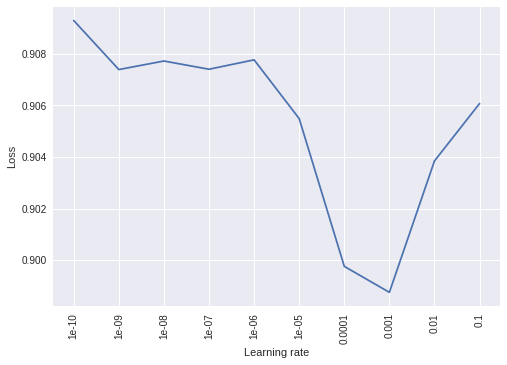

In [196]:
find_lr(model=model, loss=F1_Loss().cuda(), train_loader=train_loader, crop=1)

In [217]:
lr=5e-4
# lr=1e-3

In [219]:
model.freeze_pretrained(True)

HYPERPARAMETERS
 ______________________________ 
Batch size (w. augs): 64
Learning rate: 0.0005
Number of Epochs: 1
 ______________________________
Epoch 1 [10% done] - Training Loss: 0.9785, Elapsed Time: 26s
Epoch 1 [21% done] - Training Loss: 0.9737, Elapsed Time: 26s
Epoch 1 [31% done] - Training Loss: 0.9690, Elapsed Time: 26s
Epoch 1 [42% done] - Training Loss: 0.9666, Elapsed Time: 26s
Epoch 1 [52% done] - Training Loss: 0.9651, Elapsed Time: 26s
Epoch 1 [63% done] - Training Loss: 0.9610, Elapsed Time: 26s
Epoch 1 [73% done] - Training Loss: 0.9569, Elapsed Time: 26s
Epoch 1 [84% done] - Training Loss: 0.9596, Elapsed Time: 26s
Epoch 1 [94% done] - Training Loss: 0.9576, Elapsed Time: 26s
---------------------------------------- 
End of Epoch 1 Validation F1: 0.1057
 ________________________________________
TRAINING COMPLETE - Total Elapsed Time: 8m12s


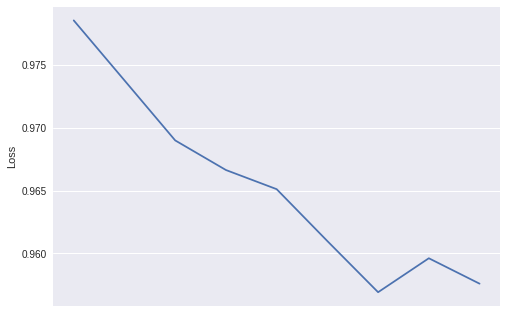

In [220]:
train_cnn(model=model, train_loader=train_loader, val_loader=val_loader, lr=lr, n_epochs=1,
          annealing=True, cycles=1, t=0.3)

In [221]:
f1_thresholds()

{0.1: 0.103,
 0.2: 0.1035,
 0.3: 0.1093,
 0.4: 0.1207,
 0.5: 0.1398,
 0.6: 0.1445,
 0.7: 0.1076,
 0.8: 0.0631,
 0.9: 0.0189,
 1.0: 0.0}

In [222]:
model.freeze_pretrained(False)

HYPERPARAMETERS
 ______________________________ 
Batch size (w. augs): 64
Learning rate: 0.0005
Number of Epochs: 3
 ______________________________
Epoch 1 [10% done] - Training Loss: 0.9564, Elapsed Time: 22s
Epoch 1 [21% done] - Training Loss: 0.9530, Elapsed Time: 23s
Epoch 1 [31% done] - Training Loss: 0.9492, Elapsed Time: 22s
Epoch 1 [42% done] - Training Loss: 0.9462, Elapsed Time: 22s
Epoch 1 [52% done] - Training Loss: 0.9454, Elapsed Time: 22s
Epoch 1 [63% done] - Training Loss: 0.9422, Elapsed Time: 22s
Epoch 1 [73% done] - Training Loss: 0.9397, Elapsed Time: 22s
Epoch 1 [84% done] - Training Loss: 0.9451, Elapsed Time: 22s
Epoch 1 [94% done] - Training Loss: 0.9446, Elapsed Time: 22s
---------------------------------------- 
End of Epoch 1 Validation F1: 0.1511
 ________________________________________
Epoch 2 [10% done] - Training Loss: 0.9440, Elapsed Time: 22s
Epoch 2 [21% done] - Training Loss: 0.9408, Elapsed Time: 22s
Epoch 2 [31% done] - Training Loss: 0.9369, Elaps

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---------------------------------------- 
End of Epoch 2 Validation F1: 0.1516
 ________________________________________
Epoch 3 [10% done] - Training Loss: 0.9322, Elapsed Time: 22s
Epoch 3 [21% done] - Training Loss: 0.9299, Elapsed Time: 22s
Epoch 3 [31% done] - Training Loss: 0.9257, Elapsed Time: 22s
Epoch 3 [42% done] - Training Loss: 0.9231, Elapsed Time: 22s
Epoch 3 [52% done] - Training Loss: 0.9213, Elapsed Time: 22s
Epoch 3 [63% done] - Training Loss: 0.9190, Elapsed Time: 22s
Epoch 3 [73% done] - Training Loss: 0.9168, Elapsed Time: 22s
Epoch 3 [84% done] - Training Loss: 0.9244, Elapsed Time: 22s
Epoch 3 [94% done] - Training Loss: 0.9239, Elapsed Time: 22s
---------------------------------------- 
End of Epoch 3 Validation F1: 0.1565
 ________________________________________
TRAINING COMPLETE - Total Elapsed Time: 22m36s


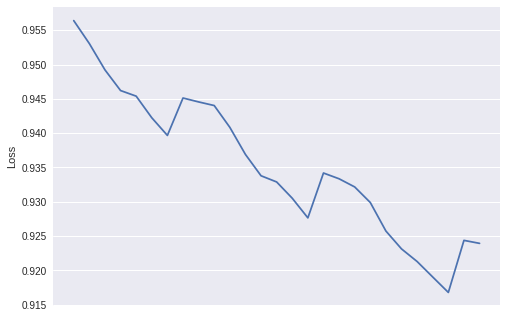

In [223]:
train_cnn(model=model, train_loader=train_loader, val_loader=val_loader, lr=lr, n_epochs=3, 
          annealing=True, cycles=1, t=opt_th())

In [224]:
f1_thresholds()

{0.1: 0.1263,
 0.2: 0.1393,
 0.3: 0.1459,
 0.4: 0.157,
 0.5: 0.1634,
 0.6: 0.1742,
 0.7: 0.1756,
 0.8: 0.1608,
 0.9: 0.1069,
 1.0: 0.0}

In [225]:
sz = 128
bs = 64
channels = "RGBY"
# n_augs = 1
dset = ProteinDataset(train, channels=channels, sz=sz)
vset = ProteinDataset(val, channels=channels, sz=sz)
train_loader = DataLoader(dset, batch_size=bs)
val_loader = DataLoader(vset, batch_size=bs)
b, y = next(iter(train_loader))

In [226]:
model.freeze_pretrained(True)

HYPERPARAMETERS
 ______________________________ 
Batch size (w. augs): 64
Learning rate: 0.0005
Number of Epochs: 1
 ______________________________
Epoch 1 [10% done] - Training Loss: 0.9343, Elapsed Time: 27s
Epoch 1 [21% done] - Training Loss: 0.9323, Elapsed Time: 27s
Epoch 1 [31% done] - Training Loss: 0.9260, Elapsed Time: 27s
Epoch 1 [42% done] - Training Loss: 0.9259, Elapsed Time: 27s
Epoch 1 [52% done] - Training Loss: 0.9230, Elapsed Time: 27s
Epoch 1 [63% done] - Training Loss: 0.9204, Elapsed Time: 27s
Epoch 1 [73% done] - Training Loss: 0.9165, Elapsed Time: 27s
Epoch 1 [84% done] - Training Loss: 0.9199, Elapsed Time: 27s
Epoch 1 [94% done] - Training Loss: 0.9156, Elapsed Time: 27s
---------------------------------------- 
End of Epoch 1 Validation F1: 0.1672
 ________________________________________
TRAINING COMPLETE - Total Elapsed Time: 8m17s


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


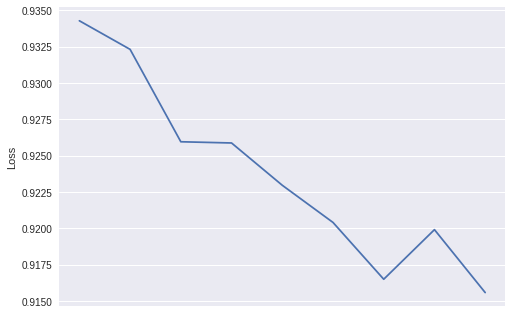

In [227]:
train_cnn(model=model, train_loader=train_loader, val_loader=val_loader, lr=lr, n_epochs=1, 
          annealing=True, cycles=1, t=opt_th())

In [228]:
f1_thresholds()

{0.1: 0.1363,
 0.2: 0.1558,
 0.3: 0.1677,
 0.4: 0.1807,
 0.5: 0.1929,
 0.6: 0.1933,
 0.7: 0.1674,
 0.8: 0.1868,
 0.9: 0.1433,
 1.0: 0.0}

In [229]:
model.freeze_pretrained(False)

HYPERPARAMETERS
 ______________________________ 
Batch size (w. augs): 64
Learning rate: 0.0005
Number of Epochs: 3
 ______________________________
Epoch 1 [10% done] - Training Loss: 0.9092, Elapsed Time: 22s
Epoch 1 [21% done] - Training Loss: 0.9092, Elapsed Time: 23s
Epoch 1 [31% done] - Training Loss: 0.9032, Elapsed Time: 22s
Epoch 1 [42% done] - Training Loss: 0.9033, Elapsed Time: 22s
Epoch 1 [52% done] - Training Loss: 0.9020, Elapsed Time: 22s
Epoch 1 [63% done] - Training Loss: 0.8999, Elapsed Time: 23s
Epoch 1 [73% done] - Training Loss: 0.8975, Elapsed Time: 23s
Epoch 1 [84% done] - Training Loss: 0.9048, Elapsed Time: 22s
Epoch 1 [94% done] - Training Loss: 0.9047, Elapsed Time: 22s
---------------------------------------- 
End of Epoch 1 Validation F1: 0.1655
 ________________________________________
Epoch 2 [10% done] - Training Loss: 0.8993, Elapsed Time: 22s
Epoch 2 [21% done] - Training Loss: 0.8983, Elapsed Time: 22s
Epoch 2 [31% done] - Training Loss: 0.8930, Elaps

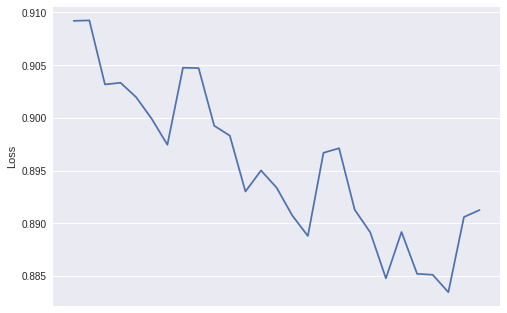

In [230]:
train_cnn(model=model, train_loader=train_loader, val_loader=val_loader, lr=lr, n_epochs=3, 
          annealing=True, cycles=1, t=opt_th())

In [231]:
f1_thresholds()

{0.1: 0.1736,
 0.2: 0.1975,
 0.3: 0.1943,
 0.4: 0.1912,
 0.5: 0.1995,
 0.6: 0.1876,
 0.7: 0.1751,
 0.8: 0.2007,
 0.9: 0.1734,
 1.0: 0.0}

In [232]:
sz = 256
bs = 32
dset = ProteinDataset(train, channels=channels, sz=sz)
vset = ProteinDataset(val, channels=channels, sz=sz)
train_loader = DataLoader(dset, batch_size=bs)
val_loader = DataLoader(vset, batch_size=bs)
b, y = next(iter(train_loader))

In [233]:
model.freeze_pretrained(True)

HYPERPARAMETERS
 ______________________________ 
Batch size (w. augs): 32
Learning rate: 0.0005
Number of Epochs: 1
 ______________________________
Epoch 1 [10% done] - Training Loss: 0.8873, Elapsed Time: 42s
Epoch 1 [20% done] - Training Loss: 0.8755, Elapsed Time: 42s
Epoch 1 [30% done] - Training Loss: 0.8752, Elapsed Time: 42s
Epoch 1 [40% done] - Training Loss: 0.8808, Elapsed Time: 42s
Epoch 1 [50% done] - Training Loss: 0.8685, Elapsed Time: 42s
Epoch 1 [60% done] - Training Loss: 0.8688, Elapsed Time: 42s
Epoch 1 [71% done] - Training Loss: 0.8610, Elapsed Time: 42s
Epoch 1 [81% done] - Training Loss: 0.8665, Elapsed Time: 41s
Epoch 1 [91% done] - Training Loss: 0.8556, Elapsed Time: 42s
---------------------------------------- 
End of Epoch 1 Validation F1: 0.1894
 ________________________________________
TRAINING COMPLETE - Total Elapsed Time: 11m50s


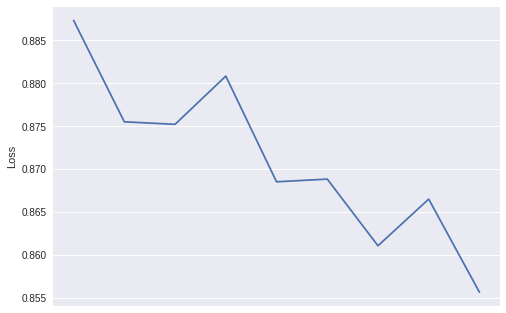

In [234]:
train_cnn(model=model, train_loader=train_loader, val_loader=val_loader, lr=lr, n_epochs=1, 
          annealing=True, cycles=1, t=opt_th())

In [235]:
f1_thresholds()

{0.1: 0.1689,
 0.2: 0.1698,
 0.3: 0.1694,
 0.4: 0.1733,
 0.5: 0.1693,
 0.6: 0.1522,
 0.7: 0.1869,
 0.8: 0.1588,
 0.9: 0.1348,
 1.0: 0.0}

In [236]:
model.freeze_pretrained(False)

HYPERPARAMETERS
 ______________________________ 
Batch size (w. augs): 32
Learning rate: 0.0005
Number of Epochs: 3
 ______________________________
Epoch 1 [10% done] - Training Loss: 0.8483, Elapsed Time: 26s
Epoch 1 [20% done] - Training Loss: 0.8439, Elapsed Time: 27s
Epoch 1 [30% done] - Training Loss: 0.8459, Elapsed Time: 26s
Epoch 1 [40% done] - Training Loss: 0.8547, Elapsed Time: 26s
Epoch 1 [50% done] - Training Loss: 0.8456, Elapsed Time: 27s
Epoch 1 [60% done] - Training Loss: 0.8475, Elapsed Time: 26s
Epoch 1 [71% done] - Training Loss: 0.8450, Elapsed Time: 26s
Epoch 1 [81% done] - Training Loss: 0.8534, Elapsed Time: 26s
Epoch 1 [91% done] - Training Loss: 0.8455, Elapsed Time: 26s
---------------------------------------- 
End of Epoch 1 Validation F1: 0.1883
 ________________________________________
Epoch 2 [10% done] - Training Loss: 0.8427, Elapsed Time: 26s
Epoch 2 [20% done] - Training Loss: 0.8356, Elapsed Time: 26s
Epoch 2 [30% done] - Training Loss: 0.8414, Elaps

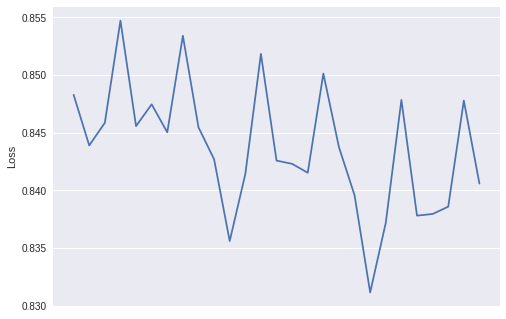

In [237]:
train_cnn(model=model, train_loader=train_loader, val_loader=val_loader, lr=lr, n_epochs=3, 
          annealing=True, cycles=1, t=opt_th())

In [238]:
f1_thresholds()

{0.1: 0.1609,
 0.2: 0.1786,
 0.3: 0.1665,
 0.4: 0.178,
 0.5: 0.1839,
 0.6: 0.1819,
 0.7: 0.1512,
 0.8: 0.1383,
 0.9: 0.1375,
 1.0: 0.0}

In [239]:
sz = 512
bs = 32
dset = ProteinDataset(train, channels=channels, sz=sz)
vset = ProteinDataset(val, channels=channels, sz=sz)
train_loader = DataLoader(dset, batch_size=bs)
val_loader = DataLoader(vset, batch_size=bs)
b, y = next(iter(train_loader))

In [240]:
model.freeze_pretrained(True)

In [ ]:
train_cnn(model=model, train_loader=train_loader, val_loader=val_loader, lr=lr, n_epochs=1, 
          annealing=True, cycles=1, t=opt_th())

In [ ]:
f1_thresholds()

In [ ]:
model.freeze_pretrained(False)

In [ ]:
train_cnn(model=model, train_loader=train_loader, val_loader=val_loader, lr=lr, n_epochs=3, 
          annealing=True, cycles=1, t=opt_th())

In [ ]:
f1_thresholds()

## Submission

In [ ]:
# len(list((PATH/'test').iterdir()))

In [ ]:
sub = pd.read_csv(PATH/'sample_submission.csv'); sub.head()

Setting the optimal threshold:

In [ ]:
def optim_thresholds():
    preds = model(b).sigmoid().cpu().data.numpy()
    targs = y.cpu().data.numpy()
    th_candidates = np.linspace(start=0.05, stop=0.95, num=100)
    thresholds = []
    for i in range(len(labels)):
        max_score = 0
        best_th = 0.02
        for th in th_candidates:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                f1 = f1_score(preds[:, i] > th, targs[:, i])
            if f1 > max_score:
                max_score = f1
                best_th = th
        thresholds.append(best_th)
    return thresholds

In [ ]:
sz = 512
bs = 256
n_augs = 0
dset = ProteinDataset(train, channels=channels, sz=sz, n_augs=n_augs)
train_loader = DataLoader(dset, batch_size=bs)
b, y = list(map(reshape, next(iter(train_loader))))

In [ ]:
th = optim_thresholds(); np.array(th)

Updating the `Predicted` column with Test Time Augmentation:

In [ ]:
%%time
for ID in sub['Id']:
#     pdb.set_trace()
    bat = torch.zeros((2, 4, 512, 512)).cuda()
    img = from_channels(ID, test=True, channels=channels)
    img2 = augment(img)
    bat[0,:,:,:] = torch.cuda.FloatTensor(np.swapaxes(img,-1,0)[None,:])
    bat[1,:,:,:] = torch.cuda.FloatTensor(np.swapaxes(img2,-1,0)[None,:])
    out = model(bat).sigmoid().mean(dim=0) > torch.cuda.FloatTensor(th)
    preds = [str(i) for i in range(len(labels)) if out[i] == 1]
    sub['Predicted'].loc[sub['Id'] == ID] = " ".join(preds if preds else "0")

Creating the submission file:

In [ ]:
now = datetime.now().strftime('%y-%m-%d-%H_%M')
sub = sub.set_index('Id')
sub.to_csv(f'submission_{now}.csv')

In [ ]:
pd.read_csv(f'submission_{now}.csv').head()